## Семинар 5: "Улучшение сходимости нейросетей"

ФИО:

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms


%matplotlib inline

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [3]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('../data', train=True, download=False, transform=transform)
test_dataset = MNIST('../data', train=False, download=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

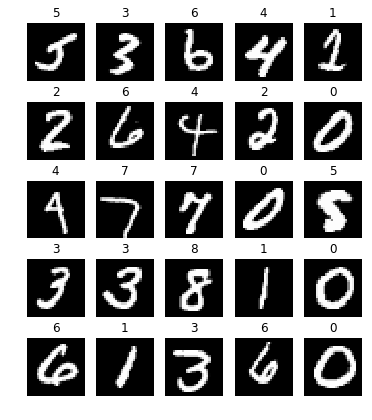

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [98]:
def init_layer(layer, mean=0.0, std=0.1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=mean, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().data[0]
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().data[0]
    print('backward', std)

    
# пример:
def get_layers(nl, ini):
    h1 = nn.Linear(28*28, 500)
    h1.register_forward_hook(forward_hook)
    h1.register_backward_hook(backward_hook)
    ini(h1)
    h2 = nn.Linear(500, 10)
    h2.register_forward_hook(forward_hook)
    h2.register_backward_hook(backward_hook)
    ini(h2)
    
    h_nl = [nl() for i in range(10)]
    h_l = [nn.Linear(500, 500) for i in range(10)]
    for h in h_l:
        h.register_forward_hook(forward_hook)
        h.register_backward_hook(backward_hook)
        ini(h)
    h_n = [(l, nl) for l, nl in zip(h_l, h_nl)]
    h_n = [item for sublist in h_n for item in sublist]
    
    return nn.Sequential(h1, nl(), *h_n, h2)


<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [134]:
##### YOUR CODE HERE #####
n_objects = 100
X = Variable(train_dataset.train_data[:n_objects], requires_grad=False).view(n_objects, -1).float()
y = Variable(train_dataset.train_labels[:n_objects], requires_grad=False)
X -= X.mean()
X /= X.std()
print('Tanh')
activations = get_layers(nn.Tanh, init_layer)(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layers_tanh.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()
print('=' * 20)
print('ReLU')
activations = get_layers(nn.ReLU, init_layer)(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layers_relu.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

Tanh
forward 0.9999999403953552
forward 0.8466970324516296
forward 0.7844488620758057
forward 0.770916759967804
forward 0.7651918530464172
forward 0.7621558904647827
forward 0.764372706413269
forward 0.764044463634491
forward 0.7646753191947937
forward 0.7634903788566589
forward 0.7646196484565735
forward 0.7652658224105835
backward 0.003001500852406025
backward 0.0005391323356889188
backward 0.0006570825935341418
backward 0.0008009422454051673
backward 0.000971737434156239
backward 0.0011855032062157989
backward 0.0014566790778189898
backward 0.0017738742753863335
backward 0.0021449693012982607
backward 0.002569636097177863
backward 0.003028351813554764
backward 0.002975765848532319
ReLU
forward 0.9999999403953552
forward 1.6085325479507446
forward 2.568206548690796
forward 4.18794059753418
forward 6.532451629638672
forward 10.467414855957031
forward 15.769492149353027
forward 24.04118537902832
forward 37.05717849731445
forward 58.6594123840332
forward 90.78836059570312
forward 137.25

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [138]:
##### YOUR CODE HERE #####
def init_layer_Xavier(layer):
    weight = layer.weight.data
    bias = layer.state_dict()['bias']
    bias.zero_()
    n, n_next = weight.size()
    span = np.sqrt(6.0 / (n + n_next))
    weight.uniform_(-span, span)

def init_layer_He(layer, mean=0, std=1):
    weight = layer.weight.data
    bias = layer.state_dict()['bias']
    bias.zero_()
    n, n_next = weight.size()
    std = np.sqrt(2.0 / n_next)
    weight.normal_(0, std)

In [140]:
n_objects = 100
X = Variable(train_dataset.train_data[:n_objects], requires_grad=False).view(n_objects, -1).float()
y = Variable(train_dataset.train_labels[:n_objects], requires_grad=False)
X -= X.mean()
X /= X.std()
print('Xavier @ Tanh')
activations = get_layers(nn.Tanh, init_layer_Xavier)(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layers_tanh.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()
print('=' * 20)
print('He @ ReLU')
activations = get_layers(nn.ReLU, init_layer_He)(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layers_relu.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

Xavier @ Tanh
forward 0.9999999403953552
forward 0.6504268050193787
forward 0.4935360848903656
forward 0.41491150856018066
forward 0.3633931577205658
forward 0.32815638184547424
forward 0.3046477735042572
forward 0.2766125798225403
forward 0.2561302185058594
forward 0.24344931542873383
forward 0.22868339717388153
forward 0.21527162194252014
backward 0.003001500852406025
backward 0.000604793312959373
backward 0.0005792404408566654
backward 0.0005477545782923698
backward 0.0005064128199592233
backward 0.00048038651584647596
backward 0.00044191244523972273
backward 0.00039400800596922636
backward 0.0003469786315690726
backward 0.0002948962210211903
backward 0.00023102789418771863
backward 0.0001526943378848955
He @ ReLU
forward 0.9999999403953552
forward 0.8425448536872864
forward 0.838310956954956
forward 0.8522908091545105
forward 0.869313657283783
forward 0.8905482292175293
forward 0.8936737179756165
forward 0.8871801495552063
forward 0.8672576546669006
forward 0.907284677028656
forwar

<i> 1.4 Сделайте выводы по первой части </i>

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [35]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры
# не забывайте, что в pyTorch нету broadcasting (делайте .expand)

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p):
        super(DropConnect, self).__init__()
        self.weight = nn.Parameter(torch.cuda.FloatTensor(input_dim, output_dim).normal_(mean=0, std=0.01), requires_grad=True)
        self.bias = nn.Parameter(torch.cuda.FloatTensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p

    def forward(self, x): 
        # TODO: if not self.trainig: return torch.mm(x, self.weight) + self.bias
        mask = torch.ones(self.weight.size(0), self.weight.size(1)) * self.p
        mask = mask.cuda()
        mask = mask.bernoulli() / self.p
        mask = Variable(mask, requires_grad=False)
        output = torch.mm(x, self.weight * mask) + self.bias
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [7]:
!export CUDA_LAUNCH_BLOCKING=1

In [45]:
def run(network, epochs):
    accs = []
    losses = []
    for i in range(epochs):
        network.train()
        for data, target in train_loader:
            data, target = data.cuda(), target.cuda()
            data = Variable(data)
            target = Variable(target, requires_grad=False)
            network.train()
            optimizer.zero_grad()
            output = network(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
        acc_ = []
        loss_ = []
        network.eval()
        for data, target in test_loader:
            target_numpy = target.numpy()
            data, target = data.cuda(), target.cuda()
            data = Variable(data, requires_grad=False)
            target = Variable(target, requires_grad=False)
            output = network(data)
            loss = loss_fn(output, target)[0]
            loss_.append(loss.data.cpu().numpy())
            acc = np.mean(np.argmax(output.data.cpu().numpy(), axis=1) == target_numpy)
            acc_.append(acc)
        accs.append(np.mean(acc_))
        losses.append(np.mean(loss_))
        print('Epoch: {}. Loss: {}. Accuracy: {}'.format(i, np.mean(loss_), np.mean(acc_)))
    return losses, accs

In [38]:
##### YOUR CODE HERE #####
class ConvNet_Dropout(nn.Module):
    def __init__(self):
        super(ConvNet_Dropout, self).__init__()
        self.linear_layers = nn.Sequential(nn.Linear(784, 200),
                                           nn.Dropout(0.5),
                                           nn.ReLU(),
                                           nn.Linear(200, 200),
                                           nn.Dropout(0.5),
                                           nn.ReLU(),
                                           nn.Linear(200, 10),
                                           nn.LogSoftmax())
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.linear_layers(x)
        return x
    
network = ConvNet_Dropout()
network.cuda()
optimizer = torch.optim.Adam(network.parameters(), lr=1e-4) 
loss_fn = torch.nn.NLLLoss()

In [39]:
losses_out, accs_out = run(network, 25)

Epoch: 0. Loss: 0.38993191719055176. Accuracy: 0.8834864217252396
Epoch: 1. Loss: 0.2838728129863739. Accuracy: 0.9157348242811502
Epoch: 2. Loss: 0.23724964261054993. Accuracy: 0.9308107028753994
Epoch: 3. Loss: 0.21560132503509521. Accuracy: 0.9369009584664537
Epoch: 4. Loss: 0.1950795203447342. Accuracy: 0.9416932907348243
Epoch: 5. Loss: 0.18131694197654724. Accuracy: 0.9463857827476039
Epoch: 6. Loss: 0.1636180281639099. Accuracy: 0.9510782747603834
Epoch: 7. Loss: 0.1608400046825409. Accuracy: 0.950379392971246
Epoch: 8. Loss: 0.15443025529384613. Accuracy: 0.9542731629392971
Epoch: 9. Loss: 0.14795835316181183. Accuracy: 0.9552715654952076
Epoch: 10. Loss: 0.14890414476394653. Accuracy: 0.9554712460063898
Epoch: 11. Loss: 0.1433742195367813. Accuracy: 0.9573682108626198
Epoch: 12. Loss: 0.13778500258922577. Accuracy: 0.9581669329073482
Epoch: 13. Loss: 0.1402508169412613. Accuracy: 0.9587659744408946
Epoch: 14. Loss: 0.13391871750354767. Accuracy: 0.9621605431309904
Epoch: 15. L

In [40]:
class ConvNet_Connect(nn.Module):
    def __init__(self):
        super(ConvNet_Connect, self).__init__()
        self.linear_layers = nn.Sequential(DropConnect(784, 200, 0.5),
                                           nn.ReLU(),
                                           DropConnect(200, 200, 0.5),
                                           nn.ReLU(),
                                           DropConnect(200, 10, 0.5),
                                           nn.LogSoftmax())
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.linear_layers(x)
        return x
    
network_con = ConvNet_Connect()
network_con.cuda()
optimizer = torch.optim.Adam(network_con.parameters(), lr=1e-4) 
loss_fn = torch.nn.NLLLoss()

In [41]:
losses_con, accs_con = run(network_con, 25)

Epoch: 0. Loss: 0.441010981798172. Accuracy: 0.8656150159744409
Epoch: 1. Loss: 0.3361952006816864. Accuracy: 0.902555910543131
Epoch: 2. Loss: 0.2839702069759369. Accuracy: 0.915535143769968
Epoch: 3. Loss: 0.23559428751468658. Accuracy: 0.926417731629393
Epoch: 4. Loss: 0.21259403228759766. Accuracy: 0.9341054313099042
Epoch: 5. Loss: 0.18742342293262482. Accuracy: 0.9417931309904153
Epoch: 6. Loss: 0.18377900123596191. Accuracy: 0.9424920127795527
Epoch: 7. Loss: 0.1634024977684021. Accuracy: 0.9501797124600639
Epoch: 8. Loss: 0.1500786691904068. Accuracy: 0.9526757188498403
Epoch: 9. Loss: 0.14522020518779755. Accuracy: 0.9564696485623003
Epoch: 10. Loss: 0.1390969306230545. Accuracy: 0.9579672523961661
Epoch: 11. Loss: 0.1339758187532425. Accuracy: 0.9608626198083067
Epoch: 12. Loss: 0.13503409922122955. Accuracy: 0.9596645367412141
Epoch: 13. Loss: 0.12576456367969513. Accuracy: 0.9606629392971247
Epoch: 14. Loss: 0.12772215902805328. Accuracy: 0.9614616613418531
Epoch: 15. Loss:

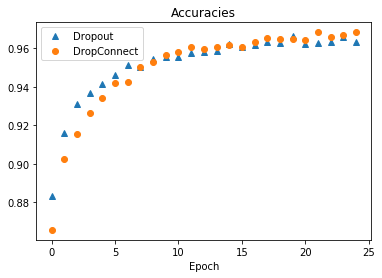

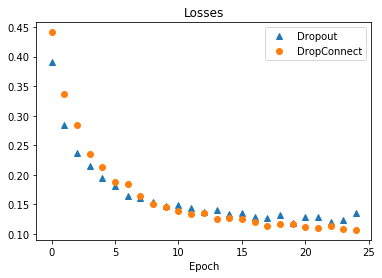

In [42]:
plt.plot(accs_out, '^', label='Dropout')
plt.plot(accs_con, 'o', label='DropConnect')
plt.legend()
plt.title('Accuracies')
plt.xlabel('Epoch')
plt.show()

plt.plot(losses_out, '^', label='Dropout')
plt.plot(losses_con, 'o', label='DropConnect')
plt.legend()
plt.title('Losses')
plt.xlabel('Epoch')
plt.show()

<i> 2.3 Сделайте выводы по третьей части </i>

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [71]:
# полезные функции: .std(dim), .mean(dim)
# не забывайте, что в pyTorch нету broadcasting (делайте .expand)

class LayerNormalization(nn.Module):
    def __init__(self, input_dim):
        super(LayerNormalization, self).__init__()
        self.g = nn.Parameter(torch.cuda.FloatTensor(input_dim).fill_(1.0), requires_grad=True)
        
    def forward(self, x):
        output = self.g * (x - torch.mean(x, 1, True)) / torch.std(x, 1, True)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [51]:
##### YOUR CODE HERE #####
class ConvNet_BN(nn.Module):
    def __init__(self):
        super(ConvNet_BN, self).__init__()
        self.linear_layers = nn.Sequential(nn.Linear(784, 200),
                                           nn.ReLU(),
                                           nn.BatchNorm1d(200),
                                           nn.Linear(200, 200),
                                           nn.ReLU(),
                                           nn.BatchNorm1d(200),
                                           nn.Linear(200, 10),
                                           nn.LogSoftmax())
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.linear_layers(x)
        return x
    
network = ConvNet_BN()
network.cuda()
optimizer = torch.optim.Adam(network.parameters(), lr=5e-4) 
loss_fn = torch.nn.NLLLoss()

In [52]:
losses_bn, accs_bn = run(network, 20)

Epoch: 0. Loss: 0.11840473860502243. Accuracy: 0.9633586261980831
Epoch: 1. Loss: 0.11234066635370255. Accuracy: 0.9731429712460063
Epoch: 2. Loss: 0.09606943279504776. Accuracy: 0.9762380191693291
Epoch: 3. Loss: 0.08594416826963425. Accuracy: 0.9773362619808307
Epoch: 4. Loss: 0.10399869084358215. Accuracy: 0.9762380191693291
Epoch: 5. Loss: 0.10767363011837006. Accuracy: 0.9763378594249201
Epoch: 6. Loss: 0.14674285054206848. Accuracy: 0.9778354632587859
Epoch: 7. Loss: 0.07739897817373276. Accuracy: 0.9830271565495208
Epoch: 8. Loss: 0.06318249553442001. Accuracy: 0.9807308306709265
Epoch: 9. Loss: 0.07069094479084015. Accuracy: 0.9795327476038339
Epoch: 10. Loss: 0.07017713040113449. Accuracy: 0.9811301916932907
Epoch: 11. Loss: 0.06724240630865097. Accuracy: 0.9810303514376997
Epoch: 12. Loss: 0.06522030383348465. Accuracy: 0.9821285942492013
Epoch: 13. Loss: 0.06224384158849716. Accuracy: 0.9812300319488818
Epoch: 14. Loss: 0.07094451785087585. Accuracy: 0.9810303514376997
Epoch

In [72]:
class ConvNet_LN(nn.Module):
    def __init__(self):
        super(ConvNet_LN, self).__init__()
        self.linear_layers = nn.Sequential(nn.Linear(784, 200),
                                           nn.ReLU(),
                                           LayerNormalization(200),
                                           nn.Linear(200, 200),
                                           nn.ReLU(),
                                           LayerNormalization(200),
                                           nn.Linear(200, 10),
                                           nn.LogSoftmax())
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.linear_layers(x)
        return x
    
network = ConvNet_LN()
network.cuda()
optimizer = torch.optim.Adam(network.parameters(), lr=5e-4) 
loss_fn = torch.nn.NLLLoss()

In [73]:
losses_ln, accs_ln = run(network, 20)

Epoch: 0. Loss: 0.10775024443864822. Accuracy: 0.9657547923322684
Epoch: 1. Loss: 0.09349916875362396. Accuracy: 0.9703474440894568
Epoch: 2. Loss: 0.08733934909105301. Accuracy: 0.9717452076677316
Epoch: 3. Loss: 0.07395988702774048. Accuracy: 0.9772364217252396
Epoch: 4. Loss: 0.08055459707975388. Accuracy: 0.9767372204472844
Epoch: 5. Loss: 0.07622461766004562. Accuracy: 0.9763378594249201
Epoch: 6. Loss: 0.07375898957252502. Accuracy: 0.9785343450479234
Epoch: 7. Loss: 0.0676819235086441. Accuracy: 0.9811301916932907
Epoch: 8. Loss: 0.06995338946580887. Accuracy: 0.9802316293929713
Epoch: 9. Loss: 0.07861891388893127. Accuracy: 0.9800319488817891
Epoch: 10. Loss: 0.071993388235569. Accuracy: 0.979832268370607
Epoch: 11. Loss: 0.07287279516458511. Accuracy: 0.9822284345047924
Epoch: 12. Loss: 0.07043267041444778. Accuracy: 0.9818290734824281
Epoch: 13. Loss: 0.07819364964962006. Accuracy: 0.9810303514376997
Epoch: 14. Loss: 0.07843354344367981. Accuracy: 0.981729233226837
Epoch: 15.

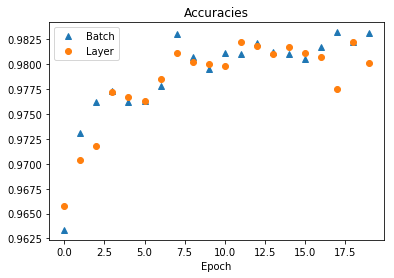

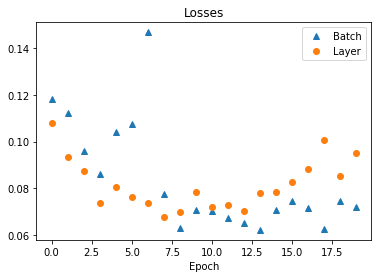

In [74]:
plt.plot(accs_bn, '^', label='Batch')
plt.plot(accs_ln, 'o', label='Layer')
plt.legend()
plt.title('Accuracies')
plt.xlabel('Epoch')
plt.show()

plt.plot(losses_bn, '^', label='Batch')
plt.plot(losses_ln, 'o', label='Layer')
plt.legend()
plt.title('Losses')
plt.xlabel('Epoch')
plt.show()

<i> 3.3 Сделайте выводы по третьей части </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: